##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 TensorFlow Lite 进行设备端训练

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/lite/examples/on_device_training/overview"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/lite/examples/on_device_training/overview.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 运行</a> </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/lite/examples/on_device_training/overview.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/lite/examples/on_device_training/overview.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

在将 TensorFlow Lite 机器学习模型部署到设备或移动应用时，您可能希望根据设备或最终用户的输入改进或个性化该模型。通过使用设备端训练技术，您可以更新模型*而无需*让数据离开用户的设备，从而提高用户隐私，并且无需用户更新设备软件。

例如，您的移动应用中可能有一个识别时尚物品的模型，但您希望用户根据他们的兴趣随着时间的推移获得更好的识别性能。启用设备端训练后，对鞋子感兴趣的用户越频繁地使用您的应用，他们就可以更好地识别特定款式的鞋子或鞋类品牌。

本教程将向您展示如何构建一个 TensorFlow Lite 模型，该模型可以在已安装的 Android 应用中进行增量训练和改进。

注：设备端训练技术可以添加到现有的 TensorFlow Lite 实现中，前提是您的目标设备支持本地文件存储。


## 安装

本教程使用 Python 训练和转换 TensorFlow 模型，然后将其整合到 Android 应用中。从安装和导入以下软件包开始。

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


注：TensorFlow 2.7 及更高版本中提供了设备端训练 API。

## 对服装图像进行分类

此示例代码使用 [Fashion MNIST 数据集](https://keras.io/api/datasets/fashion_mnist/)训练神经网络模型，用于对服装图像进行分类。该数据集包含 60,000 张小（28 x 28 像素）灰度图像，其中包含 10 种不同类别的时尚配饰，包括连衣裙、衬衫和凉鞋。

&lt;figure&gt;
  &lt;img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
       alt="Fashion MNIST images"&gt;
  &lt;figcaption&gt;&lt;b&gt;Figure 1&lt;/b&gt;: &lt;a href="https://github.com/zalandoresearch/fashion-mnist"&gt;Fashion-MNIST samples&lt;/a&gt; (by Zalando, MIT License).&lt;/figcaption&gt;
&lt;/figure&gt;

您可以在 [Keras 分类教程中](https://tensorflow.google.cn/tutorials/keras/classification#import_the_fashion_mnist_dataset)更深入探索此数据集。

## 构建用于设备端训练的模型

TensorFlow Lite 模型通常只有一个公开的函数方法（或[签名](https://tensorflow.google.cn/lite/guide/signatures)），允许您调用模型来运行推断。对于要在设备端训练和使用的模型，您必须能够执行几个单独的操作，包括训练、推断、保存和恢复模型的功能。您可以通过以下方式启用此功能：首先将 TensorFlow 模型扩展为具有多个函数，然后在将模型转换为 TensorFlow Lite 模型格式时将这些函数作为签名公开。

下面的代码示例展示了如何向 TensorFlow 模型添加以下函数：

- `train` 函数用训练数据训练模型。
- `infer` 函数调用推断。
- `save` 函数将可训练权重保存到文件系统中。
- `restore` 函数从文件系统加载可训练权重。

In [ ]:
IMG_SIZE = 28

class Model(tf.Module):

  def __init__(self):
    self.model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE), name='flatten'),
        tf.keras.layers.Dense(128, activation='relu', name='dense_1'),
        tf.keras.layers.Dense(10, name='dense_2')
    ])

    self.model.compile(
        optimizer='sgd',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True))

  # The `train` function takes a batch of input images and labels.
  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
      tf.TensorSpec([None, 10], tf.float32),
  ])
  def train(self, x, y):
    with tf.GradientTape() as tape:
      prediction = self.model(x)
      loss = self.model.loss(y, prediction)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.model.optimizer.apply_gradients(
        zip(gradients, self.model.trainable_variables))
    result = {"loss": loss}
    return result

  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
  ])
  def infer(self, x):
    logits = self.model(x)
    probabilities = tf.nn.softmax(logits, axis=-1)
    return {
        "output": probabilities,
        "logits": logits
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def save(self, checkpoint_path):
    tensor_names = [weight.name for weight in self.model.weights]
    tensors_to_save = [weight.read_value() for weight in self.model.weights]
    tf.raw_ops.Save(
        filename=checkpoint_path, tensor_names=tensor_names,
        data=tensors_to_save, name='save')
    return {
        "checkpoint_path": checkpoint_path
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def restore(self, checkpoint_path):
    restored_tensors = {}
    for var in self.model.weights:
      restored = tf.raw_ops.Restore(
          file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
          name='restore')
      var.assign(restored)
      restored_tensors[var.name] = restored
    return restored_tensors

上述代码中的 `train` 函数使用 [GradientTape](https://tensorflow.google.cn/api_docs/python/tf/GradientTape) 类记录操作，以进行自动微分。有关如何使用此类的更多信息，请参阅[梯度和自动微分简介](https://tensorflow.google.cn/guide/autodiff)。

在这里，您可以使用 Keras 模型的 `Model.train_step` 方法，而不是从头开始实现。只需注意，`Model.train_step` 返回的损失（和指标）是运行平均值，应该定期重置（通常是每个周期）。有关详细信息，请参阅[自定义 Model.fit](https://tensorflow.google.cn/guide/keras/customizing_what_happens_in_fit)。

注：此模型生成的权重被序列化为 TensorFlow 1 格式的检查点文件。

## 准备数据

获取 Fashion MNIST 数据集以训练您的模型。

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

### 预处理数据集

此数据集中的像素值介于 0 和 255 之间，必须归一化为介于 0 和 1 之间的值才能由模型进行处理。将这些值除以 255 即可进行此调整。

In [ ]:
train_images = (train_images / 255.0).astype(np.float32)
test_images = (test_images / 255.0).astype(np.float32)

通过执行独热编码将数据标签转换为分类值。

In [ ]:
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

注：请确保以相同的方式对您的*训练*数据集和*测试*数据集进行预处理，以便您的测试准确评估模型的性能。

## 训练模型。

在转换和设置 TensorFlow Lite 模型之前，请使用经过预处理的数据集和 `train` 签名方法完成模型的初始训练。以下代码会运行 100 个周期的模型训练，一次处理 100 个图像批次，并在每 10 个周期之后显示损失值。由于本次训练运行要处理相当多的数据，因此可能需要几分钟才能完成。


In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 100
epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])
m = Model()

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.batch(BATCH_SIZE)

for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = m.train(x, y)

  losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {losses[i]:.3f}")

# Save the trained weights to a checkpoint.
m.save('/tmp/model.ckpt')

Finished 10 epochs
  loss: 0.428
Finished 20 epochs
  loss: 0.378
Finished 30 epochs
  loss: 0.344
Finished 40 epochs
  loss: 0.317
Finished 50 epochs
  loss: 0.299
Finished 60 epochs
  loss: 0.283
Finished 70 epochs
  loss: 0.266
Finished 80 epochs
  loss: 0.252
Finished 90 epochs
  loss: 0.240
Finished 100 epochs
  loss: 0.230


{'checkpoint_path': <tf.Tensor: shape=(), dtype=string, numpy=b'/tmp/model.ckpt'>}

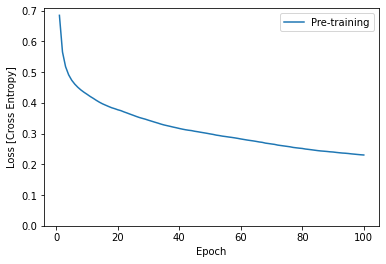

In [ ]:
plt.plot(epochs, losses, label='Pre-training')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

注：您应该在将模型转换为 TensorFlow Lite 格式*之前*完成模型的初始训练，以便模型具有初始权重集，并且能够在开始收集数据并在设备上进行训练运行之前执行合理的推断。

## 将模型转换为 TensorFlow Lite 格式

扩展 TensorFlow 模型以启用设备端训练的附加功能并完成模型的初始训练后，可以将其转换为 TensorFlow Lite 格式。以下代码会将您的模型转换并保存为该格式，包括您在设备端与 TensorFlow Lite 模型一起使用的签名集：`train, infer, save, restore`。

In [ ]:
SAVED_MODEL_DIR = "saved_model"

tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        'infer':
            m.infer.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

### 设置 TensorFlow Lite 签名

您在上一步中保存的 TensorFlow Lite 模型包含几个函数签名。您可以通过 `tf.lite.Interpreter` 类访问它们，并分别调用每个 `restore`、`train`、`save` 和 `infer` 签名。

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

infer = interpreter.get_signature_runner("infer")

比较原始模型和转换后的精简模型的输出：

In [ ]:
logits_original = m.infer(x=train_images[:1])['logits'][0]
logits_lite = infer(x=train_images[:1])['logits'][0]

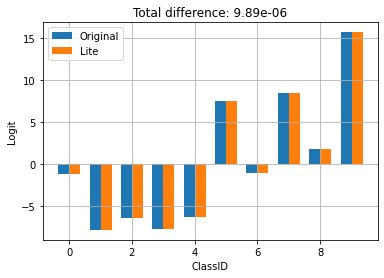

In [ ]:
#@title
def compare_logits(logits):
  width = 0.35
  offset = width/2
  assert len(logits)==2

  keys = list(logits.keys())
  plt.bar(x = np.arange(len(logits[keys[0]]))-offset,
      height=logits[keys[0]], width=0.35, label=keys[0])
  plt.bar(x = np.arange(len(logits[keys[1]]))+offset,
      height=logits[keys[1]], width=0.35, label=keys[1])
  plt.legend()
  plt.grid(True)
  plt.ylabel('Logit')
  plt.xlabel('ClassID')

  delta = np.sum(np.abs(logits[keys[0]] - logits[keys[1]]))
  plt.title(f"Total difference: {delta:.3g}")

compare_logits({'Original': logits_original, 'Lite': logits_lite})

在上面，您可以看到模型的行为不会因为转换为 TFLite 而改变。

## 在设备端重新训练模型

在将模型转换为 TensorFlow Lite 并将其用您的应用进行部署后，您可以使用新数据和模型的 `train` 签名方法在设备端重新训练模型。每次训练运行都会生成一组新的权重，您可以保存这些权重以供重用和进一步改进模型，如下一部分所示。

注：由于训练任务是资源密集型任务，您应该考虑在用户不主动与设备交互时执行这些任务，并将其作为后台进程。请考虑使用 [WorkManager](https://developer.android.com/topic/libraries/architecture/workmanager) API 将模型重新训练安排为异步任务。

在 Android 上，您可以使用 Java 或 C++API 使用TensorFlow Lite 执行设备端训练。在 Java 中，使用 `Interpreter` 类加载模型并驱动模型训练任务。以下示例展示了如何使用 `runSignature` 方法运行训练过程：


```Java
try (Interpreter interpreter = new Interpreter(modelBuffer)) {
    int NUM_EPOCHS = 100;
    int BATCH_SIZE = 100;
    int IMG_HEIGHT = 28;
    int IMG_WIDTH = 28;
    int NUM_TRAININGS = 60000;
    int NUM_BATCHES = NUM_TRAININGS / BATCH_SIZE;

    List<FloatBuffer> trainImageBatches = new ArrayList<>(NUM_BATCHES);
    List<FloatBuffer> trainLabelBatches = new ArrayList<>(NUM_BATCHES);

    // Prepare training batches.
    for (int i = 0; i < NUM_BATCHES; ++i) {
        FloatBuffer trainImages = FloatBuffer.allocateDirect(BATCH_SIZE * IMG_HEIGHT * IMG_WIDTH).order(ByteOrder.nativeOrder());
        FloatBuffer trainLabels = FloatBuffer.allocateDirect(BATCH_SIZE * 10).order(ByteOrder.nativeOrder());

        // Fill the data values...
        trainImageBatches.add(trainImages.rewind());
        trainImageLabels.add(trainLabels.rewind());
    }

    // Run training for a few steps.
    float[] losses = new float[NUM_EPOCHS];
    for (int epoch = 0; epoch < NUM_EPOCHS; ++epoch) {
        for (int batchIdx = 0; batchIdx < NUM_BATCHES; ++batchIdx) {
            Map<String, Object> inputs = new HashMap<>();
            inputs.put("x", trainImageBatches.get(batchIdx));
            inputs.put("y", trainLabelBatches.get(batchIdx));

            Map<String, Object> outputs = new HashMap<>();
            FloatBuffer loss = FloatBuffer.allocate(1);
            outputs.put("loss", loss);

            interpreter.runSignature(inputs, outputs, "train");

            // Record the last loss.
            if (batchIdx == NUM_BATCHES - 1) losses[epoch] = loss.get(0);
        }

        // Print the loss output for every 10 epochs.
        if ((epoch + 1) % 10 == 0) {
            System.out.println(
              "Finished " + (epoch + 1) + " epochs, current loss: " + loss.get(0));
        }
    }

    // ...
}
```


您可以在[模型个性化演示应用](https://github.com/tensorflow/examples/blob/master/lite/examples/model_personalization/android/transfer_api/src/main/java/org/tensorflow/lite/examples/transfer/api/LiteMultipleSignatureModel.java)中看到 Android 应用内模型重新训练的完整代码示例。

运行几个周期的训练，以改进或个性化模型。在实践中，您将使用在设备端收集的数据来运行此附加训练。为简单起见，本例使用与上一个训练步骤相同的训练数据。

In [ ]:
train = interpreter.get_signature_runner("train")

NUM_EPOCHS = 50
BATCH_SIZE = 100
more_epochs = np.arange(epochs[-1]+1, epochs[-1] + NUM_EPOCHS + 1, 1)
more_losses = np.zeros([NUM_EPOCHS])


for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = train(x=x, y=y)
  more_losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {more_losses[i]:.3f}")

Finished 10 epochs
  loss: 0.223
Finished 20 epochs
  loss: 0.216
Finished 30 epochs
  loss: 0.210
Finished 40 epochs
  loss: 0.204
Finished 50 epochs
  loss: 0.198


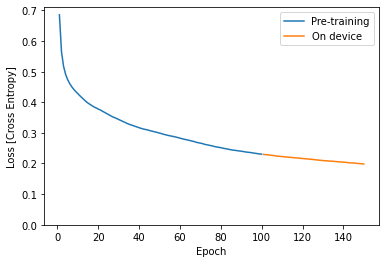

In [ ]:
plt.plot(epochs, losses, label='Pre-training')
plt.plot(more_epochs, more_losses, label='On device')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

您可以从上面看到，设备端训练正好在预训练停止的地方开始。

## 保存训练后的权重

当您在设备端完成训练运行后，模型会更新它在内存中使用的权重集。使用您在 TensorFlow Lite 模型中创建的 `save` 签名方法，您可以将这些权重保存到检查点文件中以供以后重用，并改进您的模型。

In [ ]:
save = interpreter.get_signature_runner("save")

save(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

{'checkpoint_path': array(b'/tmp/model.ckpt', dtype=object)}

在您的 Android 应用中，您可以将生成的权重作为检查点文件存储在为您的应用分配的内部存储空间中。

```Java
try (Interpreter interpreter = new Interpreter(modelBuffer)) {
    // Conduct the training jobs.

    // Export the trained weights as a checkpoint file.
    File outputFile = new File(getFilesDir(), "checkpoint.ckpt");
    Map&lt;String, Object&gt; inputs = new HashMap&lt;&gt;();
    inputs.put("checkpoint_path", outputFile.getAbsolutePath());
    Map&lt;String, Object&gt; outputs = new HashMap&lt;&gt;();
    interpreter.runSignature(inputs, outputs, "save");
}
```

## 恢复训练后的权重

每当您从 TFLite 模型创建解释器时，解释器都会首先加载原始的模型权重。

因此，在完成一些训练并保存检查点文件后，您将需要运行 `restore` 签名方法来加载检查点。

一个良好的规则是“每当为模型创建解释器时，如果检查点存在，就加载该检查点”。如果需要将模型重置为基线行为，只需删除检查点并创建新的解释器。


In [ ]:
another_interpreter = tf.lite.Interpreter(model_content=tflite_model)
another_interpreter.allocate_tensors()

infer = another_interpreter.get_signature_runner("infer")
restore = another_interpreter.get_signature_runner("restore")

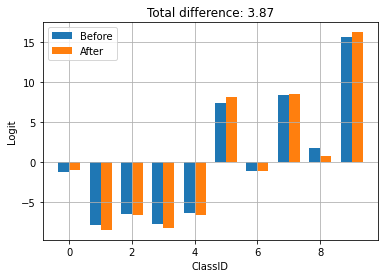

In [ ]:
logits_before = infer(x=train_images[:1])['logits'][0]

# Restore the trained weights from /tmp/model.ckpt
restore(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

logits_after = infer(x=train_images[:1])['logits'][0]

compare_logits({'Before': logits_before, 'After': logits_after})

检查点是通过使用 TFLite 进行训练和保存而生成的。在上面您可以看到，应用检查点会更新模型的行为。

注：根据模型中变量的数量和检查点文件的大小，从检查点加载保存的权重可能需要一些时间。


在您的 Android 应用中，您可以从之前存储的检查点文件中恢复序列化的、经过训练的权重。

```Java
try (Interpreter anotherInterpreter = new Interpreter(modelBuffer)) {
    // Load the trained weights from the checkpoint file.
    File outputFile = new File(getFilesDir(), "checkpoint.ckpt");
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("checkpoint_path", outputFile.getAbsolutePath());
    Map<String, Object> outputs = new HashMap<>();
    anotherInterpreter.runSignature(inputs, outputs, "restore");
}
```

注：当您的应用重新启动时，您应该在运行新的推断之前重新加载训练后的权重。

## 使用训练后的权重运行推断

从检查点文件加载以前保存的权重后，运行 `infer` 方法将这些权重与原始模型一起使用，以改进预测。加载保存的权重后，可以使用 `infer` 签名方法，如下图所示。

注：加载保存的权重并不是运行推断所必需的，但以该配置运行会使用最初训练的模型生成预测，而不会进行改进。

In [ ]:
infer = another_interpreter.get_signature_runner("infer")
result = infer(x=test_images)
predictions = np.argmax(result["output"], axis=1)

true_labels = np.argmax(test_labels, axis=1)

In [ ]:
result['output'].shape

(10000, 10)

绘制预测的标签。

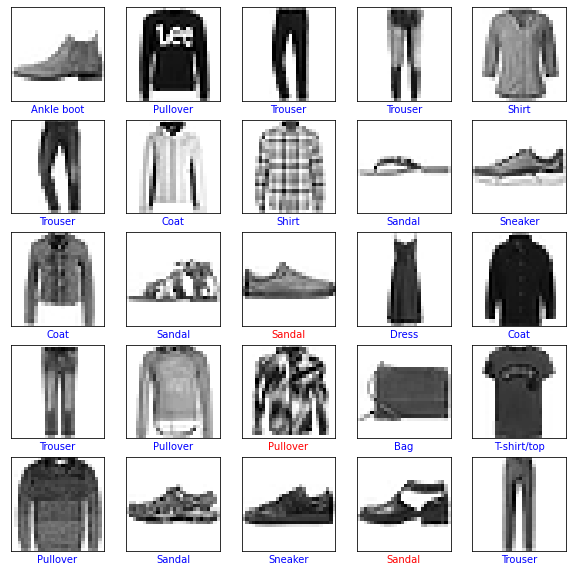

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot(images, predictions, true_labels):
  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      color = 'b' if predictions[i] == true_labels[i] else 'r'
      plt.xlabel(class_names[predictions[i]], color=color)
  plt.show()

plot(test_images, predictions, true_labels)

In [ ]:
predictions.shape

(10000,)

在您的 Android 应用中，在恢复训练的权重后，根据加载的数据运行推断。

```Java
try (Interpreter anotherInterpreter = new Interpreter(modelBuffer)) {
    // Restore the weights from the checkpoint file.

    int NUM_TESTS = 10;
    FloatBuffer testImages = FloatBuffer.allocateDirect(NUM_TESTS * 28 * 28).order(ByteOrder.nativeOrder());
    FloatBuffer output = FloatBuffer.allocateDirect(NUM_TESTS * 10).order(ByteOrder.nativeOrder());

    // Fill the test data.

    // Run the inference.
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("x", testImages.rewind());
    Map<String, Object> outputs = new HashMap<>();
    outputs.put("output", output);
    anotherInterpreter.runSignature(inputs, outputs, "infer");
    output.rewind();

    // Process the result to get the final category values.
    int[] testLabels = new int[NUM_TESTS];
    for (int i = 0; i < NUM_TESTS; ++i) {
        int index = 0;
        for (int j = 1; j < 10; ++j) {
            if (output.get(i * 10 + index) < output.get(i * 10 + j)) index = testLabels[j];
        }
        testLabels[i] = index;
    }
}
```

恭喜！您现在已经构建了一个支持设备端训练的 TensorFlow Lite 模型。有关更多编程详情，请查看[模型个性化演示应用](https://github.com/tensorflow/examples/tree/master/lite/examples/model_personalization)中的示例实现。

如果您有兴趣了解更多关于图像分类的知识，请查看 TensorFlow 官方指南页面中的 [Kera 分类教程](https://tensorflow.google.cn/tutorials/keras/classification)。本教程以该练习为基础，在分类主题上提供了更深入的内容。
